# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

In [2]:
message="        Versions        "
print("*"*len(message))
print(message)
print("*"*len(message))
print("Numpy version={}".format(np.__version__))
print("Pandas version={}".format(pd.__version__))
print("Matplotlib version={}".format(matplotlib.__version__))

************************
        Versions        
************************
Numpy version=1.16.5
Pandas version=0.25.1
Matplotlib version=3.1.1


# Importing data

In [3]:
file = open("C:/chat.txt", mode='r', encoding="utf8")
data = file.read()
file.close()

In [4]:
len(data)

2770956

# Defining tokens

In [5]:
# filtering out system generated messages, capturing only chats
# for example: "28/03/2020, 13:38 - +65 1234 5678: Expect the infection numbers to go up quite fast."
chatpattern = re.compile(r"(?P<date>\d{2}\/\d{2}\/\d{4}),\s(?P<time>\d{2}:\d{2})\s-\s(?P<sender>\D\d{2}\s\d{4}\s\d{4}):\s(?P<message>[\s\S]+?)(?=^\d{2}\/\d{2}\/\d{4}|\Z)", re.S | re.M)

In [6]:
chat = re.findall(chatpattern, data)

# Parsing data into dataframe

In [7]:
df = pd.DataFrame(chat, columns=("Date", "Time", "Sender", "Message"))

# Anonymising data

In [8]:
df['Sender'] = 'Person' + pd.Series(pd.factorize(df['Sender'])[0] + 1).astype(str)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17640 entries, 0 to 17639
Data columns (total 4 columns):
Date       17640 non-null object
Time       17640 non-null object
Sender     17640 non-null object
Message    17640 non-null object
dtypes: object(4)
memory usage: 551.4+ KB


In [12]:
print("There was a total of %d messages captured in this data." % len(df))

There was a total of 17640 messages captured in this data.


In [13]:
df.describe()

,Date,Time,Sender,Message
count,17640,17640,17640,17640
unique,49,879,149,16141
top,07/04/2020,21:25,Person5,<Media omitted>\n
freq,1042,58,2600,734


- Most number of messages were sent on 7 April 2020. There was a total of 1,042 messages.
- A total of 149 unique senders was recorded participating in this chat.
- Person5 sent the most number of messages. A total of 2,600 was sent.
- There was a total of 734 media being shared in this chat. Media includes images, attachments, etc.

In [14]:
# to confirm there is no missing value
df.isnull().sum()

Date       0
Time       0
Sender     0
Message    0
dtype: int64

In [15]:
# convert the data type of 'Date' ad 'Time'
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [16]:
# convert the data type of 'Time'
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour

In [17]:
df.head()

,Date,Time,Sender,Message,Hour
0,2020-03-26,08:19,Person1,https://www.facebook.com/1279122248765381/post...,8
1,2020-03-26,10:02,Person1,"Dear contributors, \nWelcome back! Our chat wi...",10
2,2020-03-26,10:06,Person2,One of the impt ways is not allowing misinform...,10
3,2020-03-26,10:08,Person3,Stop the fake news😀\n,10
4,2020-03-26,10:09,Person4,How when we don’t know it’s fake?\n,10


In [18]:
df.to_csv("REACH whatsapp chat_cleaned.csv", index=False)

# Exploratory Data Analysis

## Breakdown of messages by month

In [19]:
# Get Month from Date
df['Month']=df['Date'].dt.month

In [20]:
month_count = df.groupby(['Month'])['Month'].count()
print(month_count)

Month
3     2408
4    13438
5     1794
Name: Month, dtype: int64


In [21]:
# average messages in each month
# although these are not accurate cos the data was not captured 24h of each day in each month
avg_march = 2408/6
print(avg_march)

avg_april = 13438/31
print(avg_april)

avg_may = 1794/14
print(avg_may)

401.3333333333333
433.48387096774195
128.14285714285714


## Breakdown of messages by dates

In [22]:
datedf = df.groupby(['Date']).count()
datedf.head()

,Time,Sender,Message,Hour,Month
Date,,,,,
2020-03-26,646,646,646,646,646
2020-03-27,576,576,576,576,576
2020-03-28,276,276,276,276,276
2020-03-29,511,511,511,511,511
2020-03-30,154,154,154,154,154


In [23]:
date_min = datedf.index[(datedf["Message"] == datedf['Message'].min())].tolist()[0]
date_max = datedf.index[(datedf["Message"] == datedf['Message'].max())].tolist()[0]

In [24]:
print("The minimum number of message sent is {} on {}.".format(datedf["Message"].min(), date_min))
print("The maximum number of message sent is {} on {}.".format(datedf["Message"].max(), date_max))

The minimum number of message sent is 3 on 2020-05-13 00:00:00.
The maximum number of message sent is 1042 on 2020-04-07 00:00:00.


Text(0.5, 1.0, 'Number of messages per day')

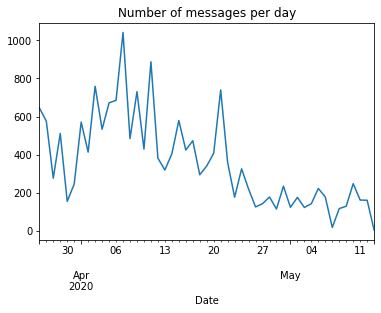

In [25]:
df.groupby(df['Date']).size().plot()
plt.title('Number of messages per day')

## Breakdown of messages by hour

In [26]:
# breakdown of messages by hour
hour_count = df.groupby(['Hour'])['Hour'].count()
print(hour_count)

Hour
0       23
7        2
8        7
9       25
10     564
11     650
12    1871
13    1708
14    1943
15    1573
16    1387
17    1402
18    1135
19    1501
20    1105
21    1855
22     665
23     224
Name: Hour, dtype: int64


Text(0.5, 1.0, 'Number of messages by hour')

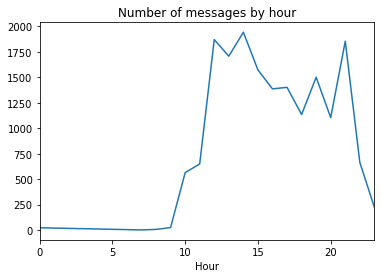

In [27]:
df.groupby(df['Hour']).size().plot()
plt.title('Number of messages by hour')

- On an average day, the chat is most active between 12pm and 3pm, which are lunch hours. There are also spikes of messages around 5pm and 9pm, which could be when most people are getting off work and after their dinner etc respectively.

In [28]:
# detailed breakdown of hour by day
date_hour = df.groupby(['Date','Hour'])['Hour'].count()
print(date_hour)

Date        Hour
2020-03-26  8         1
            10      111
            11       78
            12       43
            13       54
                   ... 
2020-05-12  21        1
            22        1
            23        1
2020-05-13  10        1
            11        2
Name: Hour, Length: 638, dtype: int64


## Examining senders

In [29]:
# how many unique senders
df['Sender'].nunique()

149

Text(0.5, 0, 'Number of messages sent')

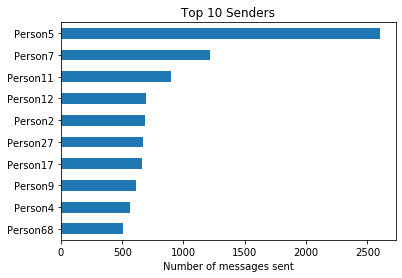

In [30]:
# top 10 senders / talkative senders
sender_count = df['Sender'].value_counts() # Number of messages per author
top10_sender_count = sender_count.head(10) # Number of messages per author for the top 10 most active authors

# graph sorted by descending order
top10_sender_count_sorted = top10_sender_count.sort_values(ascending=True)
top10_sender_count_sorted.plot.barh()
plt.title('Top 10 Senders')
plt.xlabel('Number of messages sent')

In [31]:
sender_count = df.groupby('Sender')['Sender'].count()
print(sender_count)

Sender
Person1      205
Person10     123
Person100      7
Person101      4
Person102      1
            ... 
Person95       4
Person96       1
Person97       9
Person98       6
Person99      12
Name: Sender, Length: 149, dtype: int64


## Examining messages

In [32]:
df['Message'] = df.Message.astype(str)

In [33]:
# remove rows that contain media
df = df[~df.Message.str.contains('<Media omitted>')]

In [34]:
df['Letter_Count'] = df['Message'].apply(lambda s : len(s))
df['Word_Count'] = df['Message'].apply(lambda s : len(s.split(' ')))

In [35]:
df['Letter_Count'].sum(), df['Word_Count'].sum()

(2122073, 344607)

In [36]:
print("There is a total of {:,} letters and {:,} words used in this chat.".format(df['Letter_Count'].sum(), df['Word_Count'].sum()))

There is a total of 2,122,073 letters and 344,607 words used in this chat.


In [37]:
df.head()

,Date,Time,Sender,Message,Hour,Month,Letter_Count,Word_Count
0,2020-03-26,08:19,Person1,https://www.facebook.com/1279122248765381/post...,8,3,70,1
1,2020-03-26,10:02,Person1,"Dear contributors, \nWelcome back! Our chat wi...",10,3,625,101
2,2020-03-26,10:06,Person2,One of the impt ways is not allowing misinform...,10,3,499,83
3,2020-03-26,10:08,Person3,Stop the fake news😀\n,10,3,20,4
4,2020-03-26,10:09,Person4,How when we don’t know it’s fake?\n,10,3,34,7


Text(0, 0.5, 'Sender')

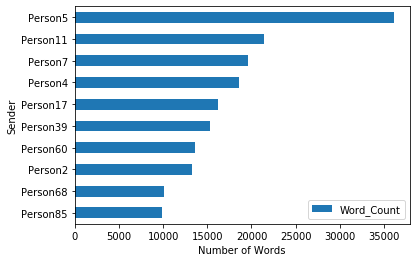

In [38]:
# finding top 10 number of words by sender
wordcount_sender = df[['Sender', 'Word_Count']].groupby('Sender').sum()
sorted_wordcount_sender = wordcount_sender.sort_values('Word_Count', ascending=False)
top10sorted_wordcount_sender = sorted_wordcount_sender.head(10)
top10sorted_wordcount_sender.plot.barh().invert_yaxis() #arrange the bars in descending order
plt.xlabel('Number of Words')
plt.ylabel('Sender')

Text(0, 0.5, 'Frequency')

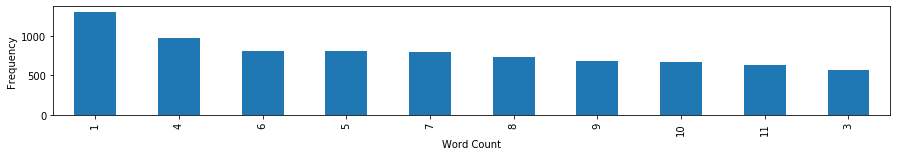

In [39]:
# most common number of words in a message
plt.figure(figsize=(15, 2))
wordcount_values = df['Word_Count'].value_counts()
top10wordcount_values = wordcount_values.head(10)
top10wordcount_values.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

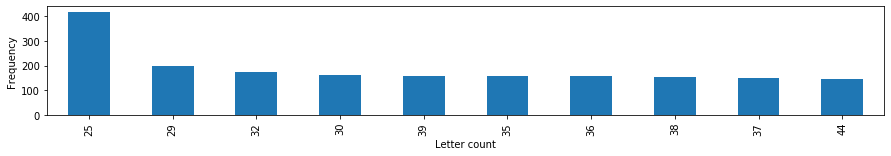

In [40]:
# most common number of letters in a message
plt.figure(figsize=(15, 2))
lettercount_values = df['Letter_Count'].value_counts()
top10lettercount_values = lettercount_values.head(10)
top10lettercount_values.plot.bar()
plt.xlabel('Letter count')
plt.ylabel('Frequency')

In [62]:
messagecontent = df['Message'].to_string()

In [63]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(messagecontent)

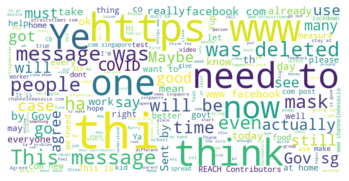

In [64]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [65]:
# adding more stopwords
stopwords = set(STOPWORDS)
stopwords.add('message')
stopwords.add('https')
stopwords.add('www')

In [66]:
wordcloud_sw = WordCloud(background_color='white', stopwords=stopwords, width=800, height=400, max_words=100).generate(messagecontent)

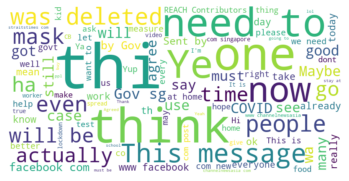

In [67]:
plt.imshow(wordcloud_sw, interpolation='bilinear')
plt.axis("off")
plt.show()

In [47]:
wordcloud.words_

{'thi': 1.0,
 'https www': 0.6395511921458625,
 'think': 0.5539971949509116,
 'one': 0.5287517531556802,
 'need to': 0.5091164095371669,
 'Ye': 0.5007012622720898,
 'now': 0.3997194950911641,
 'This message': 0.3955119214586255,
 'message was': 0.3955119214586255,
 'was deleted': 0.394109396914446,
 'people': 0.3744740532959327,
 'mask': 0.3281907433380084,
 'even': 0.3281907433380084,
 'ha': 0.2973352033660589,
 'will be': 0.2805049088359046,
 'time': 0.2762973352033661,
 'actually': 0.27489481065918653,
 'go': 0.27349228611500703,
 'Gov sg': 0.2720897615708275,
 'case': 0.270687237026648,
 'Maybe': 0.2538569424964937,
 'still': 0.2496493688639551,
 'got': 0.24684431977559607,
 'use': 0.24123422159887797,
 'will': 0.23983169705469845,
 'good': 0.23281907433380084,
 'many': 0.22019635343618513,
 'say': 0.21598877980364656,
 'must': 0.2131837307152875,
 'see': 0.20897615708274894,
 'COVID': 0.20757363253856942,
 'agree': 0.20476858345021037,
 'by Gov': 0.20196353436185133,
 'facebook co